# correlation between multiple fields, and across trial types 

In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc
import tqdm
import misc

import switch_analysis_one_session as saos
reload(saos)

reload(misc)

from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform, dice

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

67 sessions!
67 sessions!


In [2]:
db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
ii=0
data_dir_full = db_sorted['data_dir_full'][ii]
ani = db_sorted.index[ii][0]#'e15_13f1'#'e13_26m1'
sess=db_sorted['sess_name'][ii]#'e15_13f1_220117'#'e13_26m1_210913'
print(sess)

e13_26m1_210913


In [3]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [5]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [6]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [7]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [8]:
reload(pa)
fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

In [9]:
task_ind = 0
pf_fr_all = pd.concat({trial_type:pf_res['avg']['params'][task_ind,trial_type].loc['fr_mean'] for trial_type in [0,1]},axis=0)


In [10]:
pf_fr_all_peak = pd.concat({trial_type:pf_res['avg']['params'][task_ind,trial_type].loc['fr_peak'] for trial_type in [0,1]},axis=0)



In [11]:
def get_within_neuron_corr(pf_fr_all):
    gpb=pf_fr_all.groupby(level=(0,1))
    corr = {}
    c_triu_d = {}
    inds_d =  {}
    for k,v in gpb:
        if v.shape[0]>1:
            c=v.T.corr()
            corr[k] = c
            c_triu = c.values[np.triu_indices(c.shape[0],1)]
            field_inds=c.index.get_level_values(-1)
            inds0=field_inds[np.triu_indices(c.shape[0],1)[0]]
            inds1=field_inds[np.triu_indices(c.shape[0],1)[1]]
            inds_d[k] = np.array([inds0,inds1]).T
            c_triu_d[k] =  c_triu
    all_corr_df = pd.concat({k:pd.Series(v) for k,v in c_triu_d.items()})
    return all_corr_df, c_triu_d, inds_d

In [12]:
all_corr_df,c_triu_d, inds_d=get_within_neuron_corr(pf_fr_all)
all_corr_df_peak,c_triu_d_peak, inds_d_peak=get_within_neuron_corr(pf_fr_all_peak)

(array([ 2.,  9., 42., 75., 75., 51., 23.,  8.,  0.,  7.]),
 array([-0.65854471, -0.49934579, -0.34014687, -0.18094794, -0.02174902,
         0.1374499 ,  0.29664882,  0.45584775,  0.61504667,  0.77424559,
         0.93344451]),
 <BarContainer object of 10 artists>)

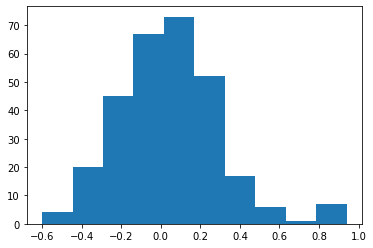

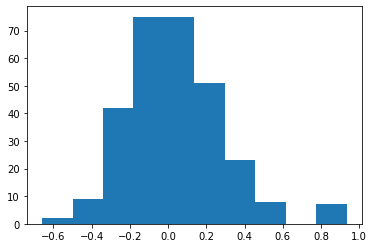

In [275]:
%matplotlib inline
plt.hist(np.concatenate(list(c_triu_d.values())))
plt.figure()
plt.hist(np.concatenate(list(c_triu_d_peak.values())))

In [13]:
def sample_bewteen_quantile(df,qq_low=0.8,qq_up=0.9,n_sample=1):
    sample = df.loc[(df>=df.quantile(qq_low))&(df<=df.quantile(qq_up))].sample(n_sample)
    return sample
    

In [20]:
qq_low = 0.0
qq_up = 0.1
task_ind=0
sample=sample_bewteen_quantile(all_corr_df,qq_low,qq_up,n_sample=12)
# tt_ind,nn = sample.index[0][:2]
# cc = sample.values[0]


In [15]:

def plot_ratemap_fr_across_trials(fr_map_trial_df_d, pf_fr_all,pf_res, sample, c_triu_d, inds_d,task_ind=0,fig=None,axs=None):
    tt_ind,nn = sample.index[0][:2]
    cc = sample.values[0]
    
    mat=fr_map_trial_df_d.loc[task_ind,tt_ind,nn].dropna(axis=1).T
    if axs is None:
        fig,axs=plt.subplots(1,2,figsize=(10,3))
    axs[0].imshow(mat,aspect='auto')
    axs[0].set_title(f'quantile {qq_low}-{qq_up}, trialtype {tt_ind}\n neuron {nn},corr {cc:.01f}')
    pf_fr_all.loc[tt_ind,nn].T.plot(marker='o',ax=axs[1])
    corr_display = '\n'.join([f'{ind_pair}:{c:.01}' for ind_pair, c in list(zip(inds_d[tt_ind,nn],c_triu_d[tt_ind,nn]))])
    coms = pf_res['avg']['all_fields'][task_ind,tt_ind].loc[nn]['com'].iteritems()
    coms = list(coms)
    axs[1].legend(coms)
    axs[1].set_title(corr_display,fontsize=12)
    return fig,axs

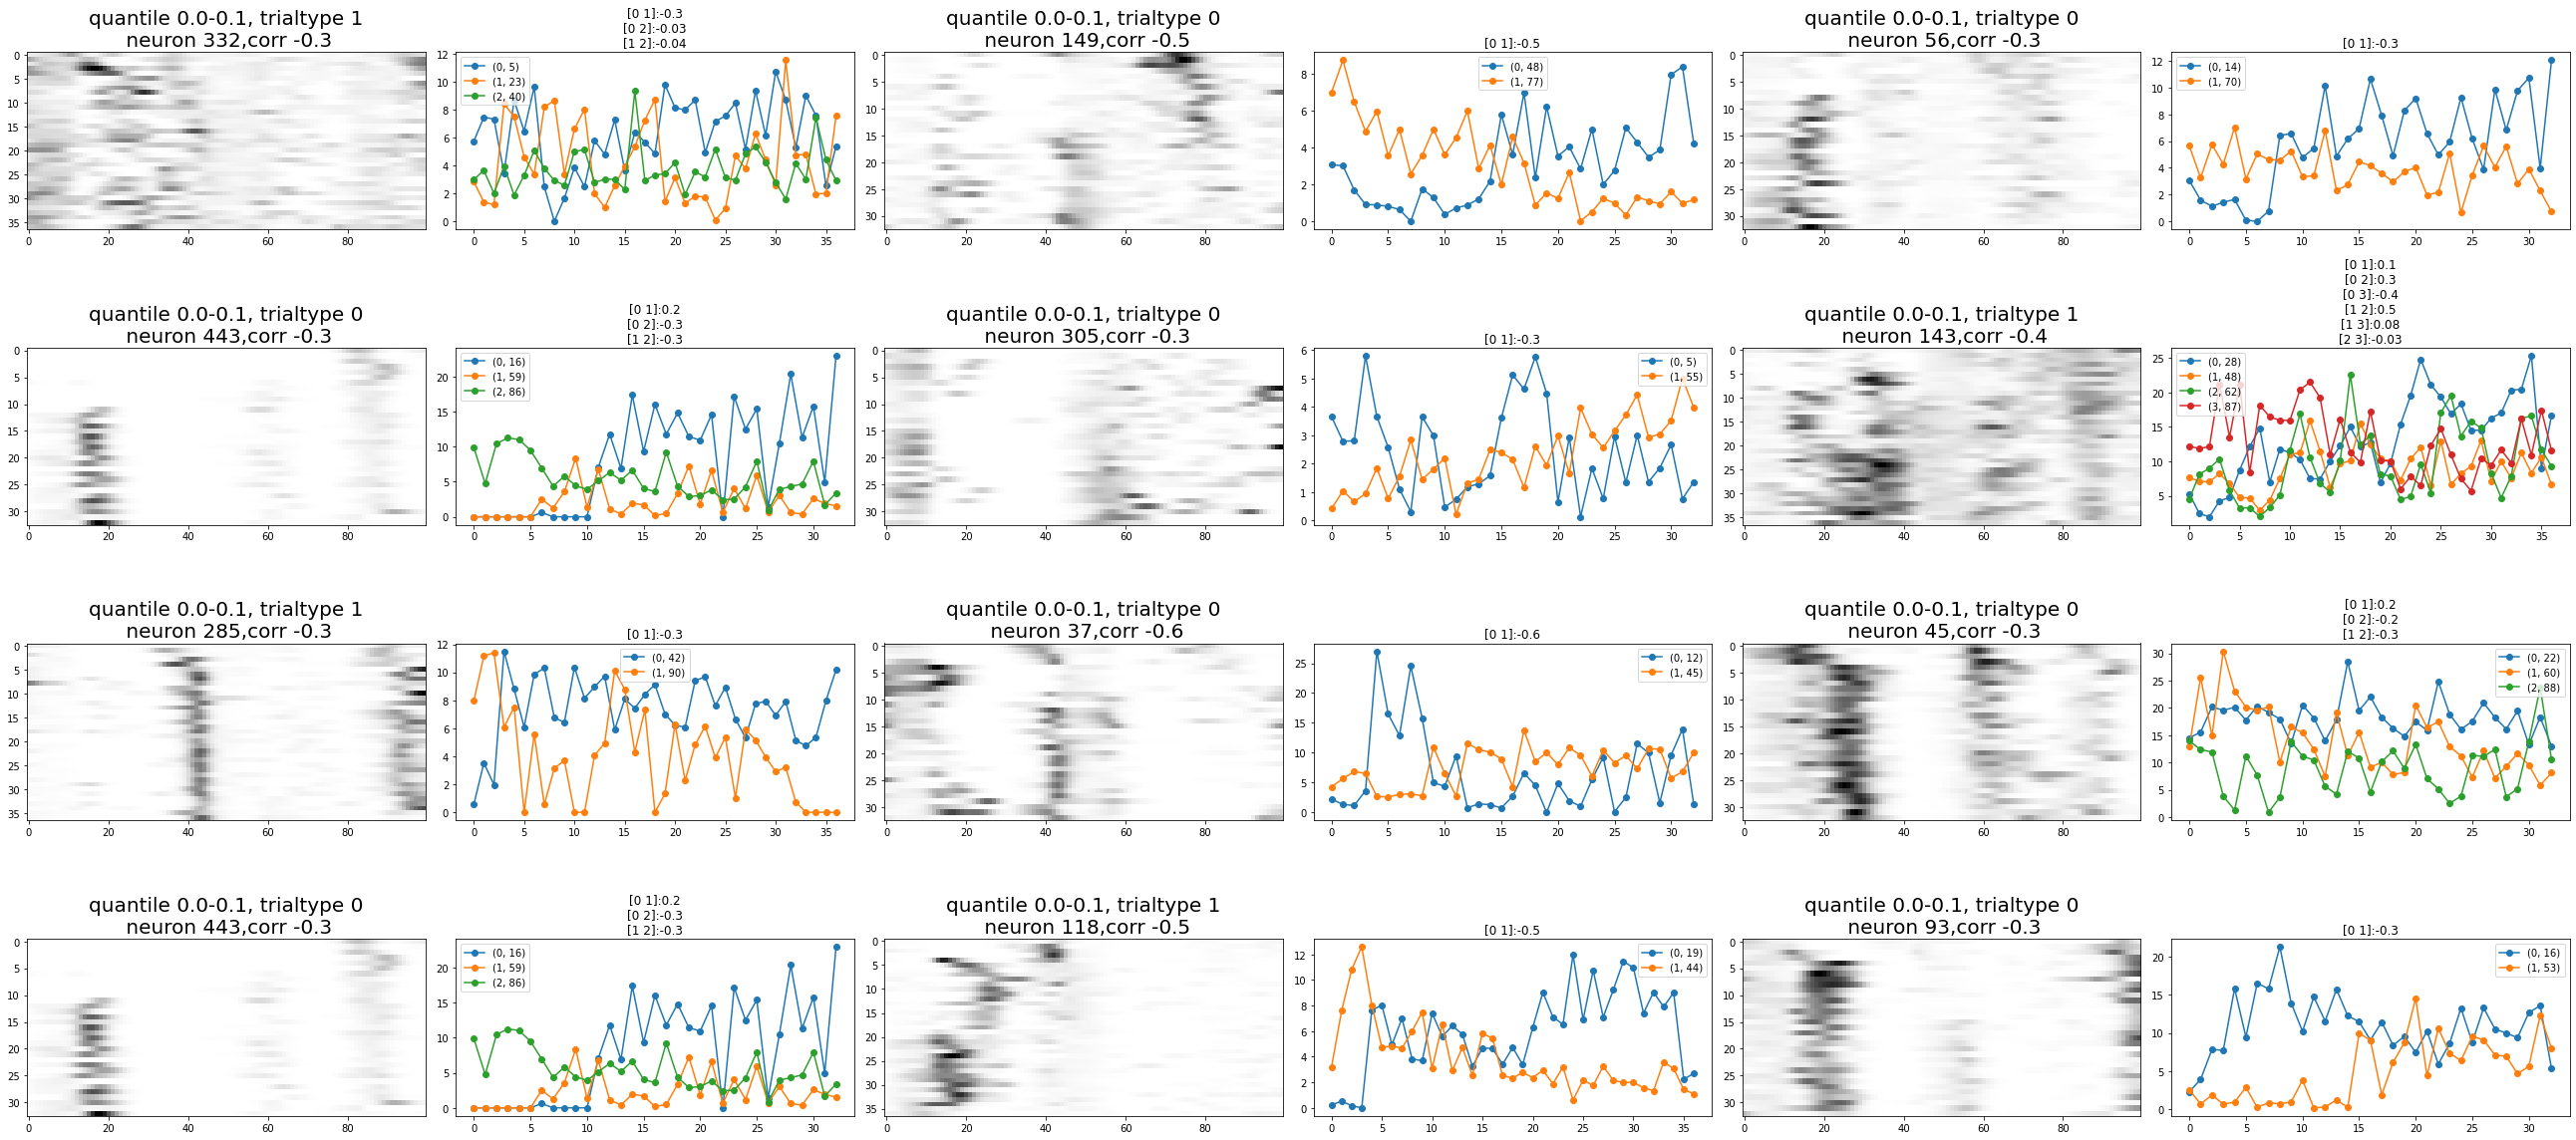

In [21]:
%matplotlib inline
nfigs = sample.shape[0]
nplots = nfigs*2
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii in range(nfigs):
    s=sample.iloc[[ii]]
    ax = axs.ravel()[ii*2:ii*2+2]
    plot_ratemap_fr_across_trials(fr_map_trial_df_d, pf_fr_all,pf_res, s, c_triu_d, inds_d,task_ind=0,fig=fig,axs=ax)
plt.tight_layout()

# is the interfield correlation a function of distance bewteen fields?

In [315]:
c_triu_d

{(0, 29): array([-0.03661654, -0.07755307,  0.25402583]),
 (0, 34): array([-0.17281715]),
 (0, 35): array([0.06868353]),
 (0, 36): array([-0.33356584, -0.13733047,  0.03572349]),
 (0, 37): array([-0.60029238]),
 (0, 43): array([ 0.2623725 , -0.04409987,  0.02365475]),
 (0, 45): array([ 0.17727895, -0.16034903, -0.29015703]),
 (0, 46): array([-0.30630927]),
 (0, 48): array([-0.25172983,  0.36037264,  0.10692428]),
 (0, 52): array([0.2504397]),
 (0, 53): array([0.08572096]),
 (0, 54): array([-0.01207126,  0.07753262, -0.06687913]),
 (0, 56): array([-0.28550732]),
 (0, 57): array([0.1434097]),
 (0, 58): array([-0.17406108, -0.35459288,  0.02925865]),
 (0, 67): array([0.2169423]),
 (0, 68): array([0.90641367]),
 (0, 82): array([-0.26537056]),
 (0, 83): array([0.0500888 , 0.33159366, 0.09734299]),
 (0, 84): array([0.7429517]),
 (0, 88): array([0.38514881, 0.09651888, 0.26984049]),
 (0, 89): array([0.02729635]),
 (0, 91): array([-0.04271647]),
 (0, 93): array([-0.32175779]),
 (0, 94): array(

In [320]:
all_fields_all = pd.concat(pf_res['avg']['all_fields'],axis=0)

In [326]:
val

array([[0, 1],
       [0, 2],
       [1, 2]])

In [332]:
val

array([[0, 1],
       [0, 2],
       [1, 2]])

In [334]:
all_fields_all.loc[task_ind,k[0],k[1]]['com'].loc[indpair,:]

IndexingError: Too many indexers

In [337]:
all_fields_all.loc[task_ind,k[0],k[1]]['com'].loc[[0,1]]

field_index
0     5
1    29
Name: com, dtype: object

In [339]:
all_fields_all.loc[task_ind,k[0],k[1]]['com'].loc[list(indpair),:]

[0, 1]

In [340]:
all_fields_all.loc[task_ind,k[0],k[1]]['com'].loc[list(indpair),:]

NameError: name 'd' is not defined

In [343]:
dist_d={}
for k,val in inds_d.items():
    dist = []
    for indpair in val:
        d = all_fields_all.loc[task_ind,k[0],k[1]]['com'].loc[list(indpair)]
        d = d.diff().values[1]
        dist.append(d)
    dist=np.array(dist)
    dist_d[k] = dist


In [349]:
all_dist_flat=np.concatenate(list(dist_d.values()))
all_c_flat = np.concatenate(list(c_triu_d.values()))

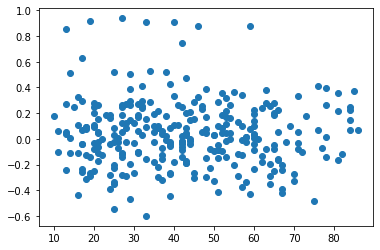

In [350]:
plt.scatter(all_dist_flat,all_c_flat)

In [351]:
scipy.stats.pearsonr(all_dist_flat,all_c_flat)

(-0.029610280623542994, 0.6143169497361735)

In [323]:
all_fields_all.loc[task_ind,k[0],k[1]]

,start,end,com,peak,fr_peak,fr_mean
field_index,,,,,,
0,51,62,56,57,1.460745,0.959989
1,78,88,83,83,1.320478,0.977215


Text(0.5, 1.0, '[0 2]:0.2')

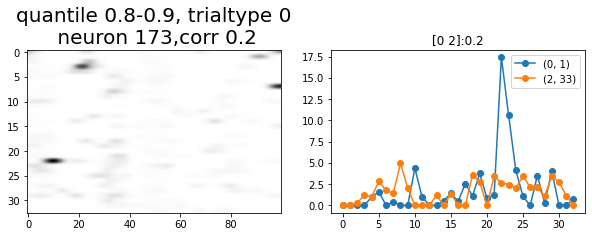

In [282]:
# # peak
# cc = all_corr_df_peak.loc[sample.index].values[0]
# mat=fr_map_trial_df_d.loc[task_ind,tt_ind,nn].dropna(axis=1).T
# fig,ax=plt.subplots(1,2,figsize=(10,3))
# ax[0].imshow(mat,aspect='auto')
# ax[0].set_title(f'quantile {qq_low}-{qq_up}, trialtype {tt_ind}\n neuron {nn},corr {cc:.01f}')
# fr_one_neuron=pf_res['avg']['params'][task_ind,tt_ind].loc['fr_peak',nn]
# fr_one_neuron.T.plot(marker='o',ax=ax[1])
# corr_display = '\n'.join([f'{ind_pair}:{c:.01}' for ind_pair, c in list(zip(inds_d_peak[tt_ind,nn],c_triu_d_peak[tt_ind,nn]))])
# coms = pf_res['avg']['all_fields'][task_ind,tt_ind].loc[nn]['peak'].iteritems()
# coms = list(coms)
# ax[1].legend(coms)
# ax[1].set_title(corr_display,fontsize=12)

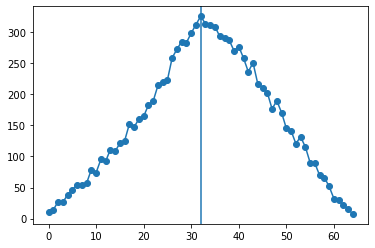

In [206]:
cc=np.correlate(one_field_fr.loc[1].values,one_field_fr.loc[2].values,mode='full')
midlind=cc.shape[0] //2
plt.plot(cc,marker='o')
plt.axvline(midlind)

In [ ]:
# first get a df for the timestamps for each field center at each trial
